# 0.0 Imports


In [2]:
import math
import random
import pickle
import warnings
import inflection
import seaborn    as sns
import numpy      as np
import pandas     as pd
warnings.filterwarnings ('ignore')


from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML
from scipy                 import stats     as ss
from matplotlib            import pyplot    as plt
from ipykernel             import kernelapp as app
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import Lasso
from sklearn.linear_model  import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics       import mean_absolute_error,mean_squared_error


## 0.1 Helper Functions

In [81]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 )):
        if verbose:
            print ('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date']< validation_start_date]
        validation = x_training [(x_training['date'] >= validation_start_date) & (x_training['date']<= validation_end_date )]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date','sales'], axis = 1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype( str) + '+/-' + np.round(np.std(mae_list), 2).astype( str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype( str) + '+/-' + np.round(np.std(mape_list), 2).astype( str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype( str) + '+/-' + np.round(np.std(rmse_list), 2).astype( str)}, index = [0])
    
def mean_percentage_error(y, yhat):
    return np.mean((y -yhat)/y)
    
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y -yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse}, index = [0])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
 jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
# low_memory=False -> ler o arquivo de uma vez para a memóris
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore (x)
cols_news = list(map( snakecase, cols_old))

#rename
df1.columns = cols_news

## 1.2 Data Dimensions

In [8]:
print( 'Number od Rowns: {}'.format(df1.shape[0]))
print( 'Number od Columns: {}'.format(df1.shape[1]))

Number od Rowns: 1017209
Number od Columns: 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'])

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6 Change Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


## 1.7 Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency - mean, median
t1 = pd.DataFrame (num_attributes.apply(np.mean)).T
t2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skwe, kutosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(np.min)).T
d3 = pd.DataFrame (num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
m1 = pd.concat([d2, d3, d4, t1, t2, d1, d5, d6]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


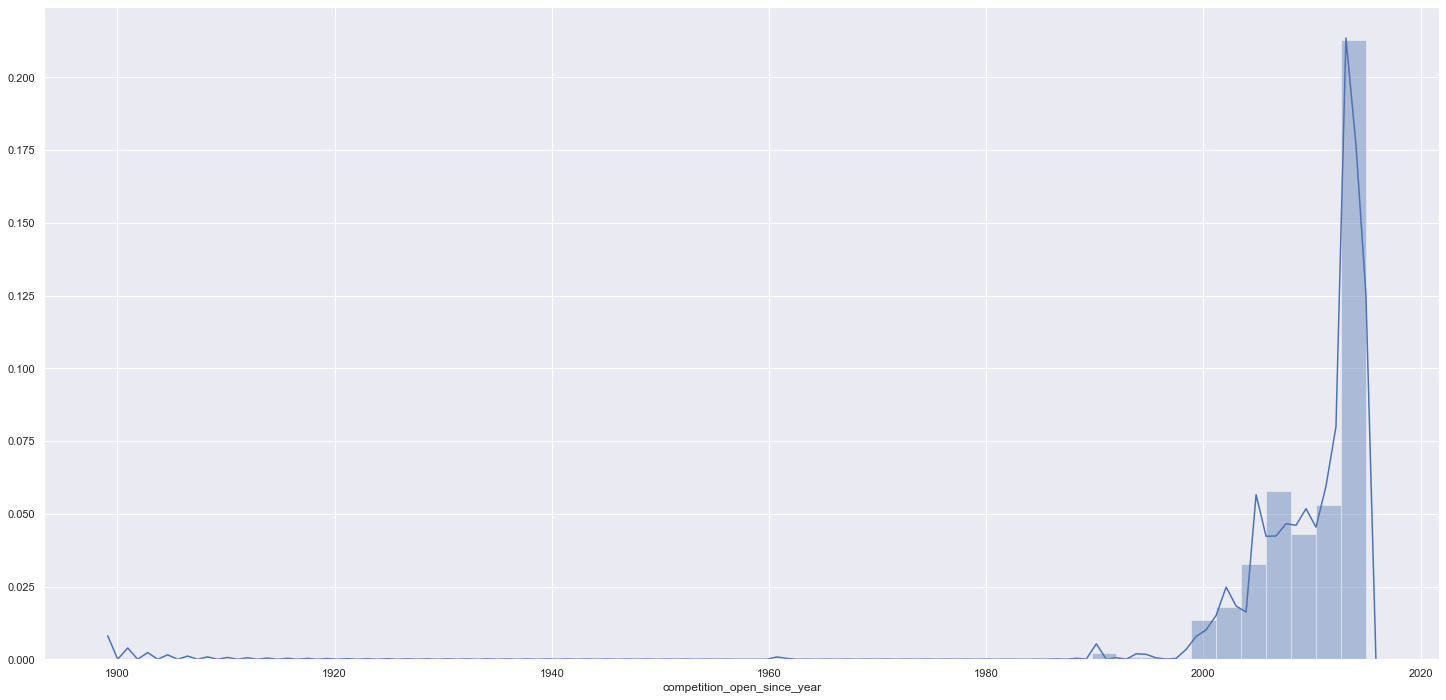

In [15]:
sns.distplot(df1['competition_open_since_year'])

### 1.7.1 Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

# 2.0 Feature Engineering

In [17]:
df2 = df1.copy()

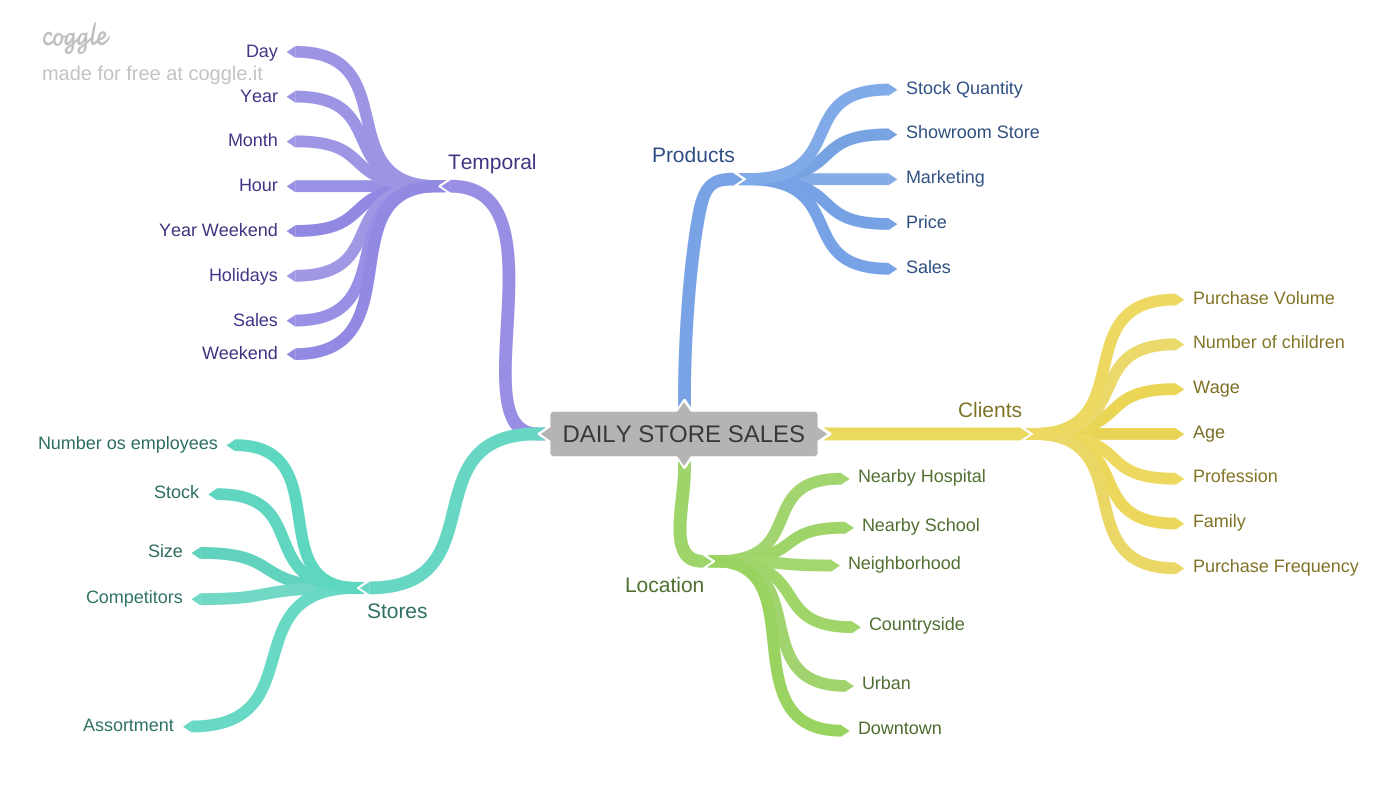

In [18]:
Image('img/Mindmap.png')


## 2.1 Mindmap Hipothesis

### 2.1.1 Store Hipothesis

**1.** Stores with greater staff should sell more.

**2.** Stores with greater stock should sell more.

**3.** Lager stores should sell more.

**4.** Smaller should sell less.

**5.** Stores with greater assortment should sell more.

**6.** Stores with close competitors should sell less.

### 2.1.2 Product Hipothesis

**1.** Stores with signficant investment in Marketing should sell more.

**2.** Stores with a greater number of products in showcase should sell more.

**3.** Stores with reduced prices should sell more.

**4.** Stores with reduced prices for a long time should sell more.

### 2.1.3 Time Hipothesis

**1.** During Chirstmas stores should sell more.

**2.** Over the years stores should sell more.

**3.** During school holidays stores should sell less.

**4.** After second week of each month stores shoud sell more.

**5.** During weekends stores should sell less.


## 2.2 Final Hypothesis list

**1.** Stores with greater assortment should sell more.

**2.** Stores with close competitors should sell less.

**3.** Stores with a longer time competitors should sell more.

**4.** Stores with reduced prices for a long time should sell more.

**5.** Stores with extended days sales should sell more.

**6.** Stores with consecutive sales should sell more.

**7.** During Chirstmas holiday, stores should sell more.

**8.** Over the years stores should sell more.

**9.** During the second semester, stores should sell more.

**10.** After day 10 of each month stores shoud sell more.

**11.** During weekends ,stores should sell less.

**12.** During school holidays, stores should sell less.

## 2.3 Feature Engineering

In [19]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week 

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int ) 

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# Promo since is a str now. The next step is convert to date. Apply only in promo_since column 
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
# result in weeks (/7) and extract days (x.days)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype( int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x == 'c' else 'regular_day')


# 3.0  Filtering

In [20]:
df3 = df2.copy()

## 3.1 Row Filtering

In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [22]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )


# 4.0 Data Mining

In [23]:
 df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

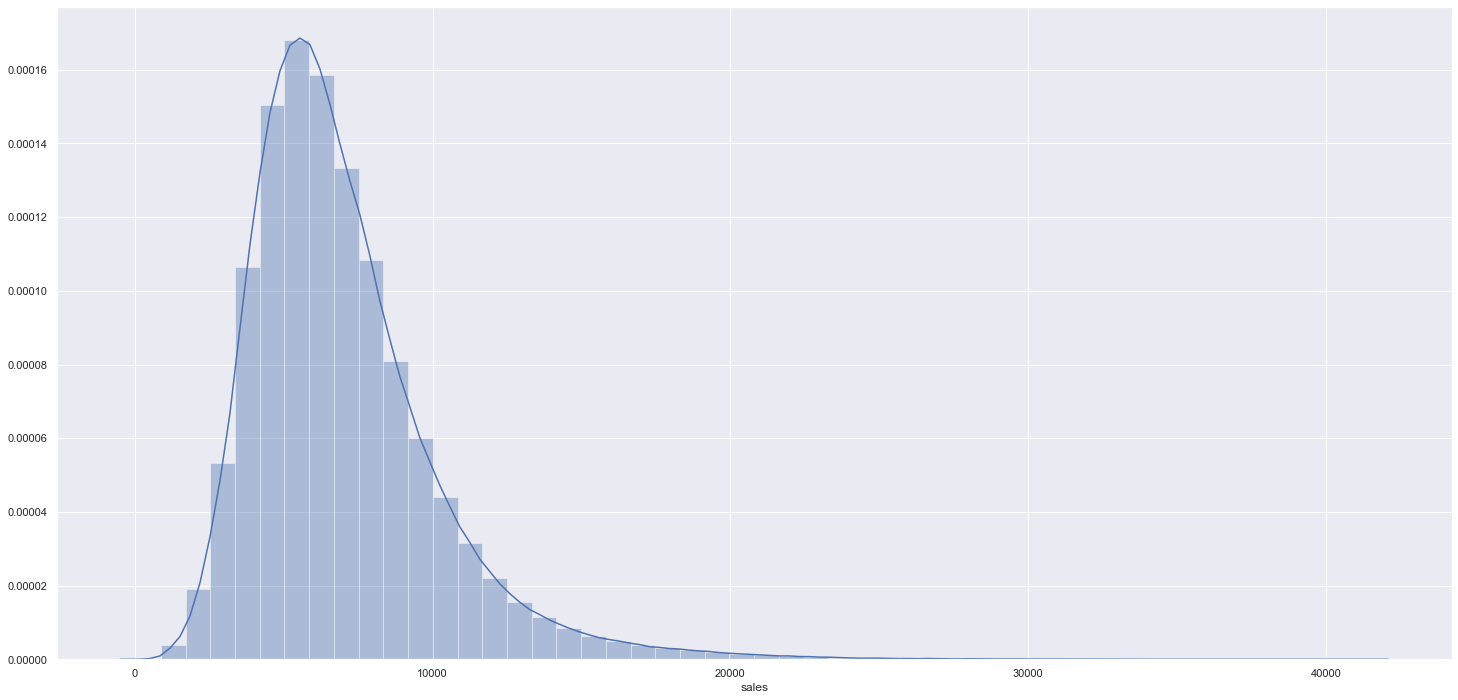

In [24]:
sns.distplot( df4['sales'] )

### 4.1.2 Numerical Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb51433c210>,
      dtype=object)

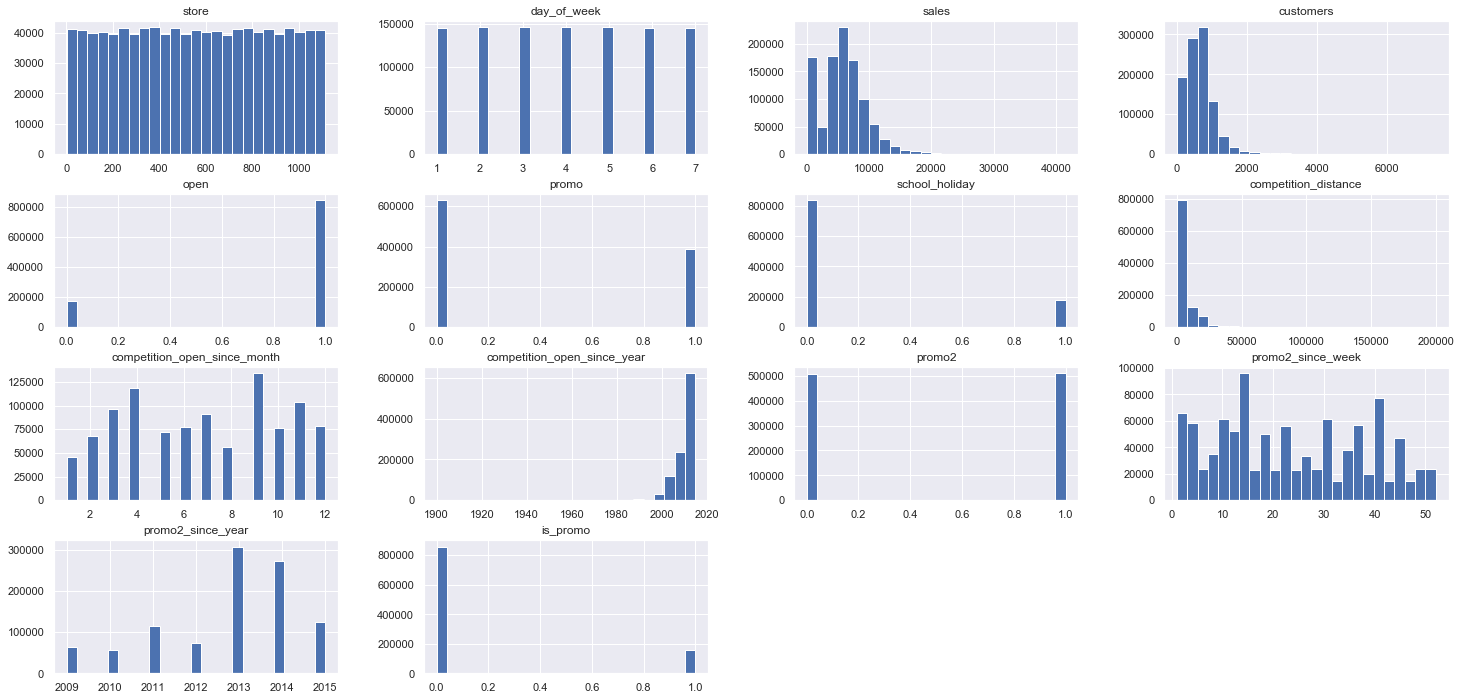

In [25]:
num_attributes.hist(bins=25)

### 4.1.3 Categorical Variable

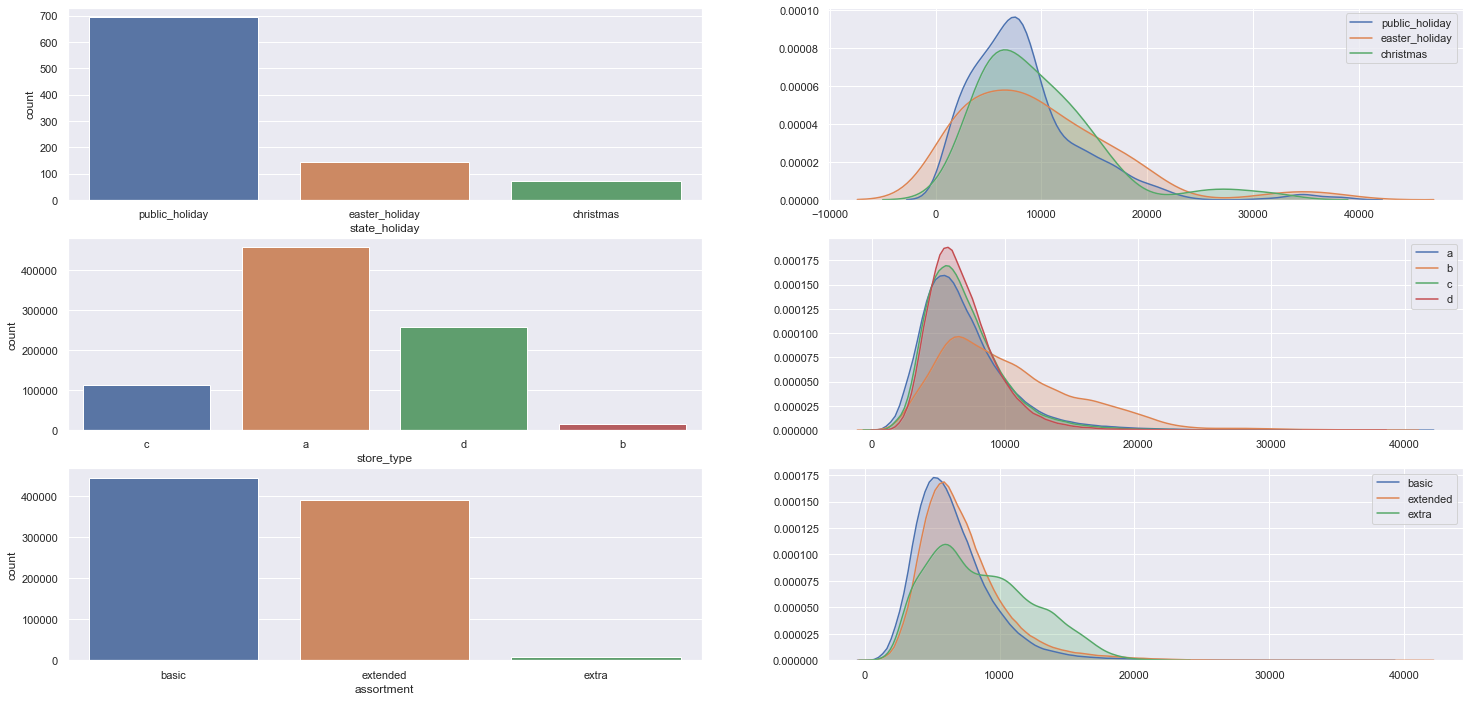

In [26]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )



### 4.2 Bivariate Analysis

**H1.** Stores with greater assortment should sell more.

**H1. Validation = False:** Stores with greater assortment **sell less.**

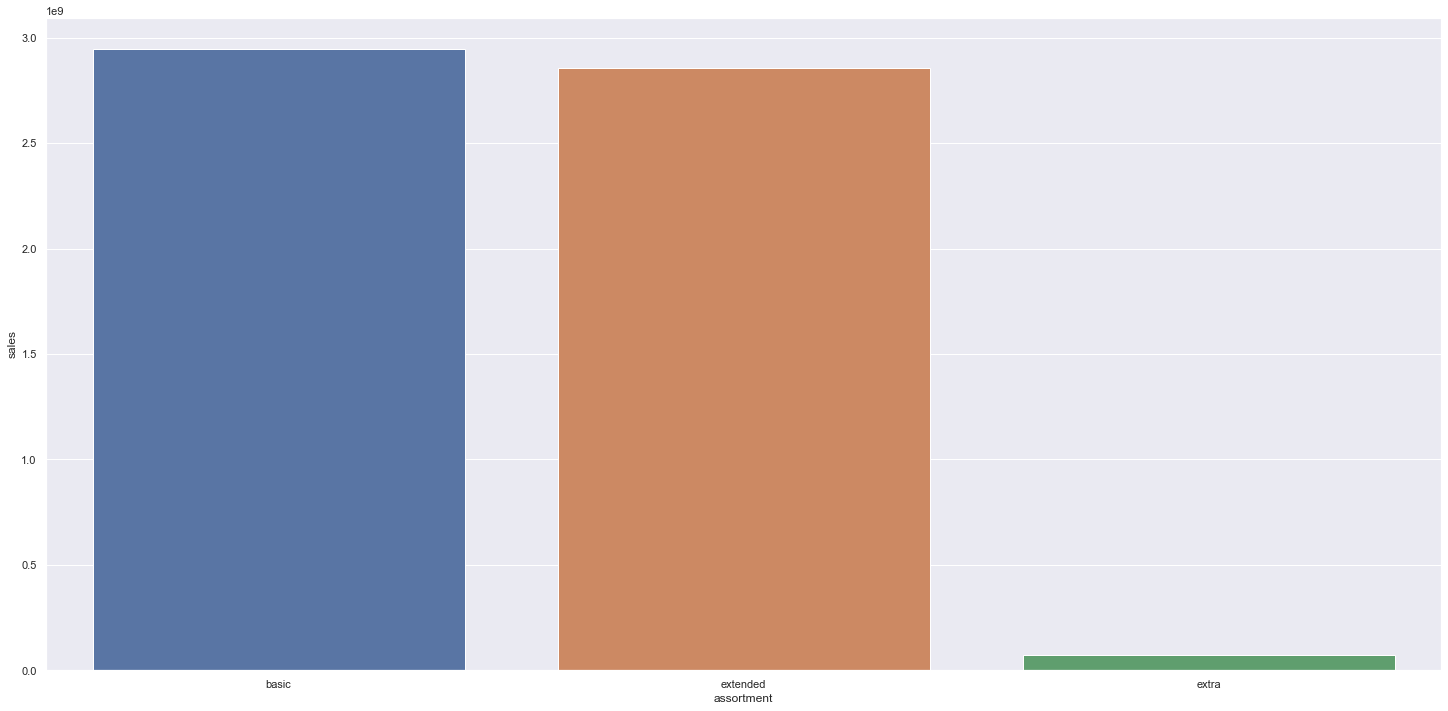

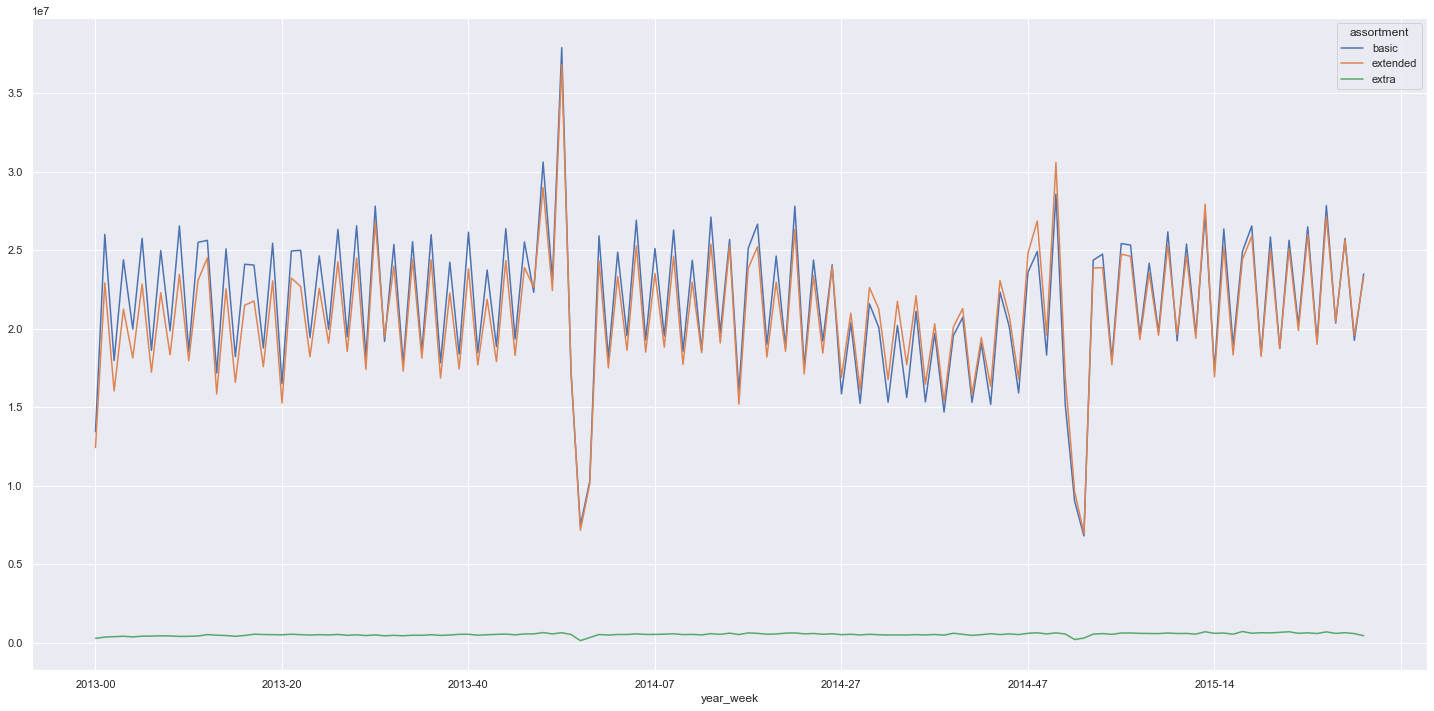

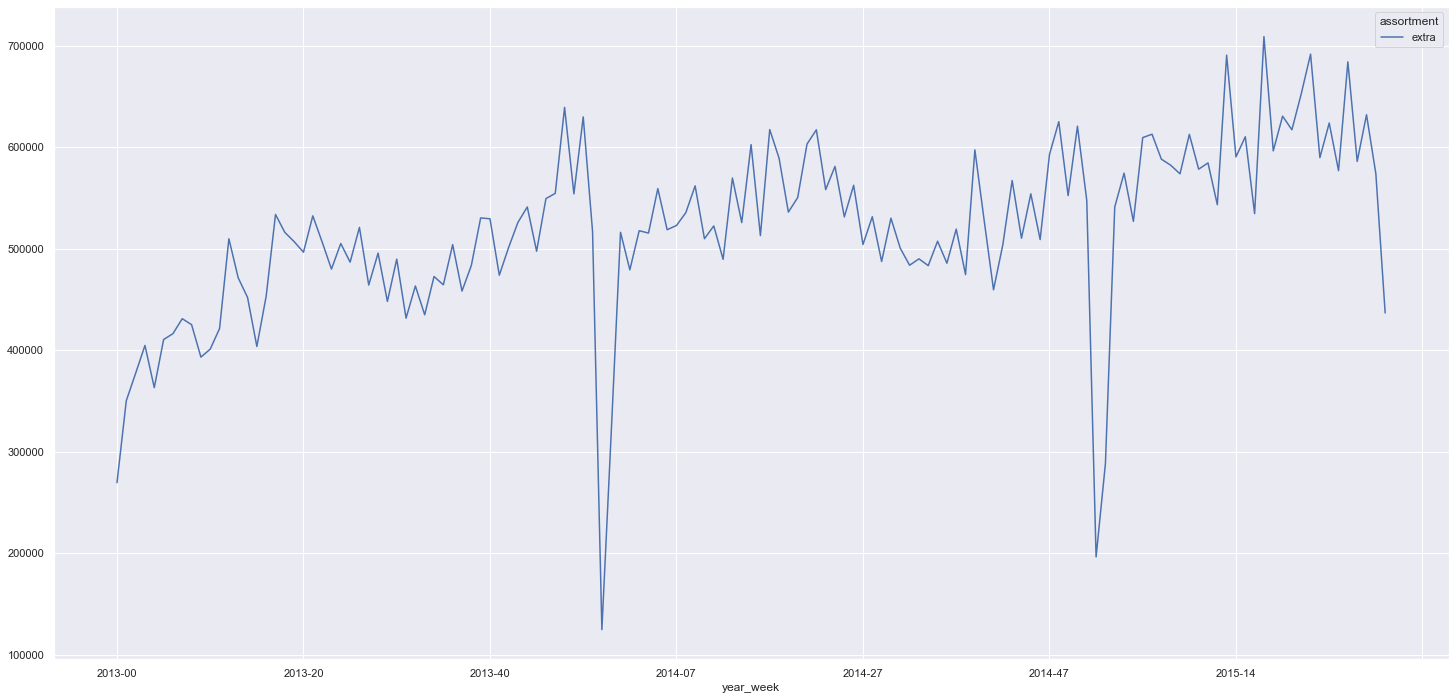

In [27]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

# basically 'basic' and 'extended' have same trend.
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot();

# 'assortment' trend
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot();

**H2.** Stores with close competitors should sell less.

**H2. Validation = False:** Stores with close competitors **sell more.**

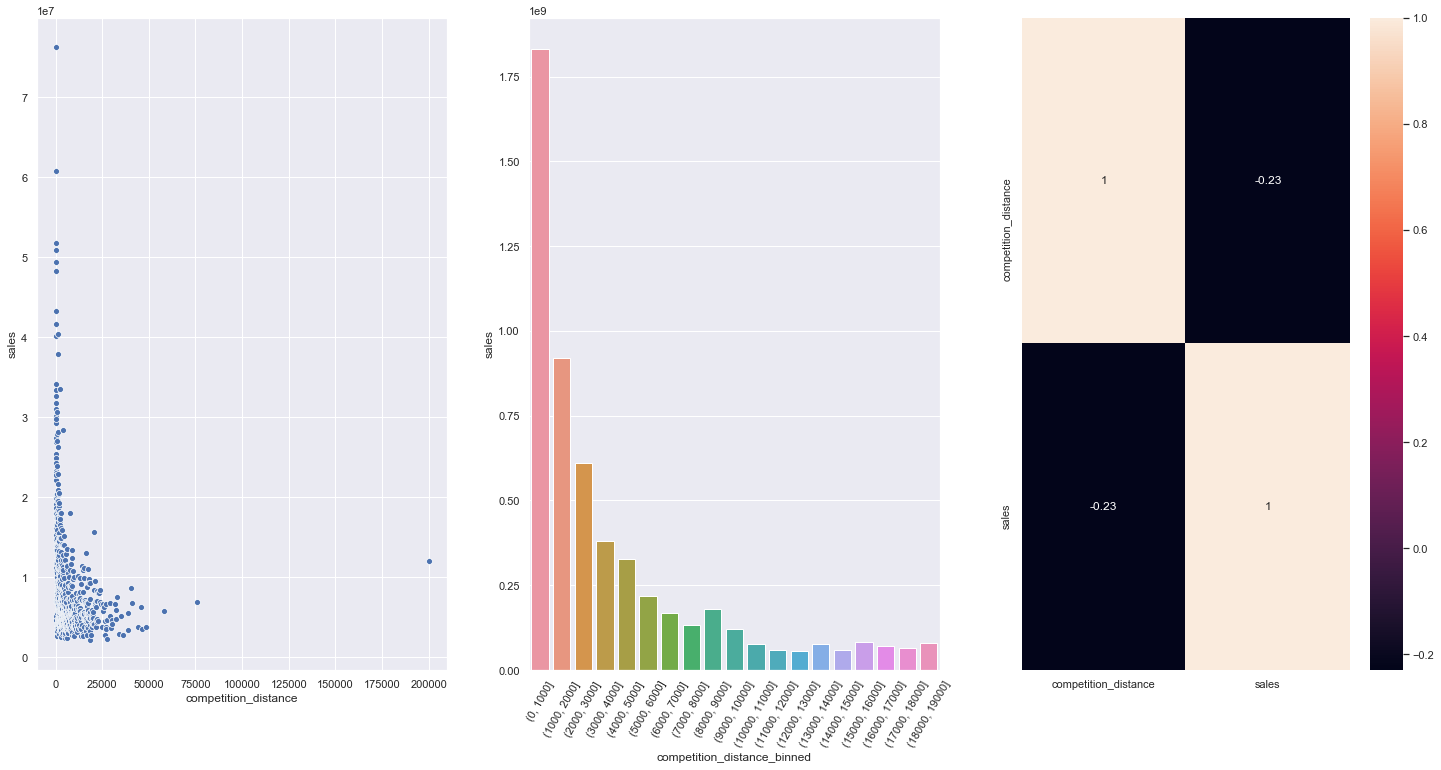

In [28]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1 )
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks (rotation=60)

# correlation('competition_distance', 'sales')
plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot = True)



**H3.** Stores with a longer time competitors should sell more.

**H3. Validation = False:** Stores with a longer time competitors **sell less.**

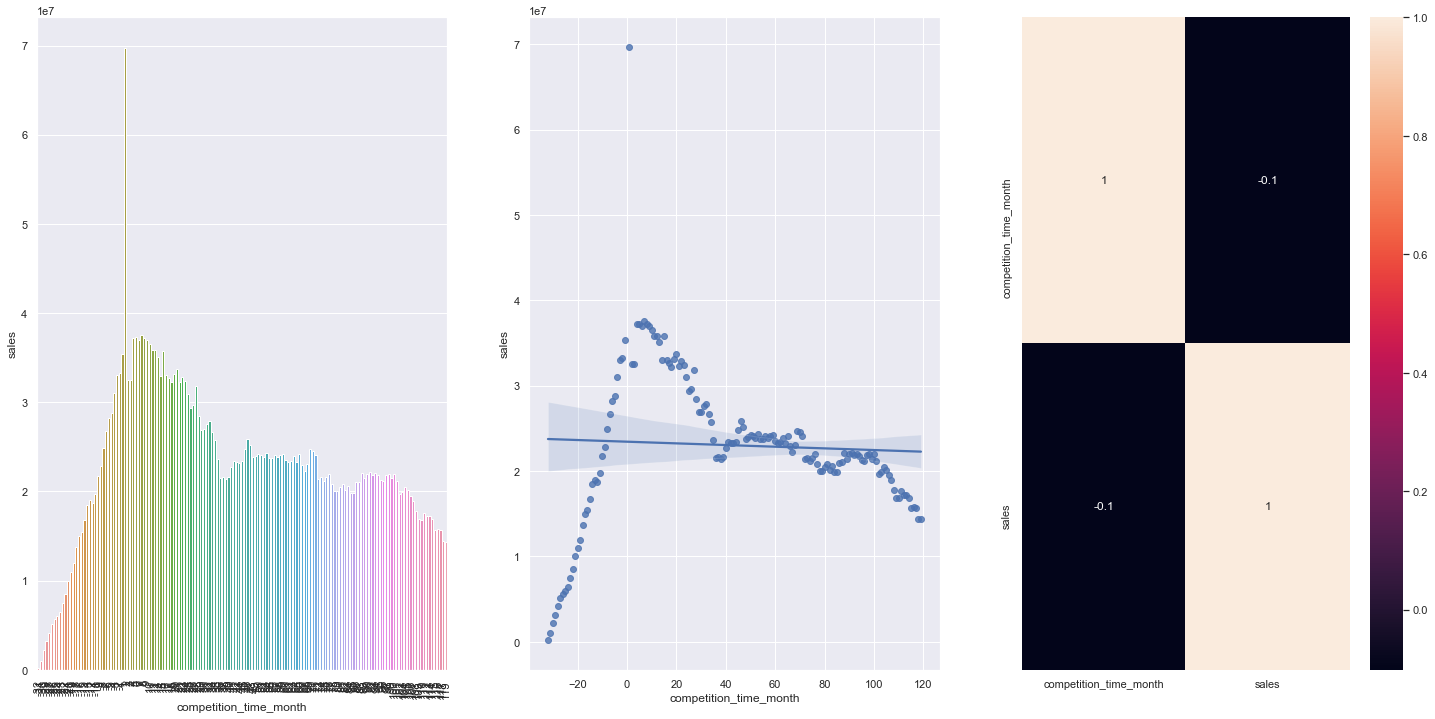

In [29]:
# When values come closer to zero, greater is the amount of sales
plt.subplot(1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks (rotation=90);

plt.subplot(1, 3, 2 )
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3 )
x = sns.heatmap(aux1.corr(method='pearson'), annot = True)

**H4.** Stores with reduced prices for a long time should sell more.

**H4. Validation = False:** Stores with reduced prices for a long time **sell less,** after a time period.

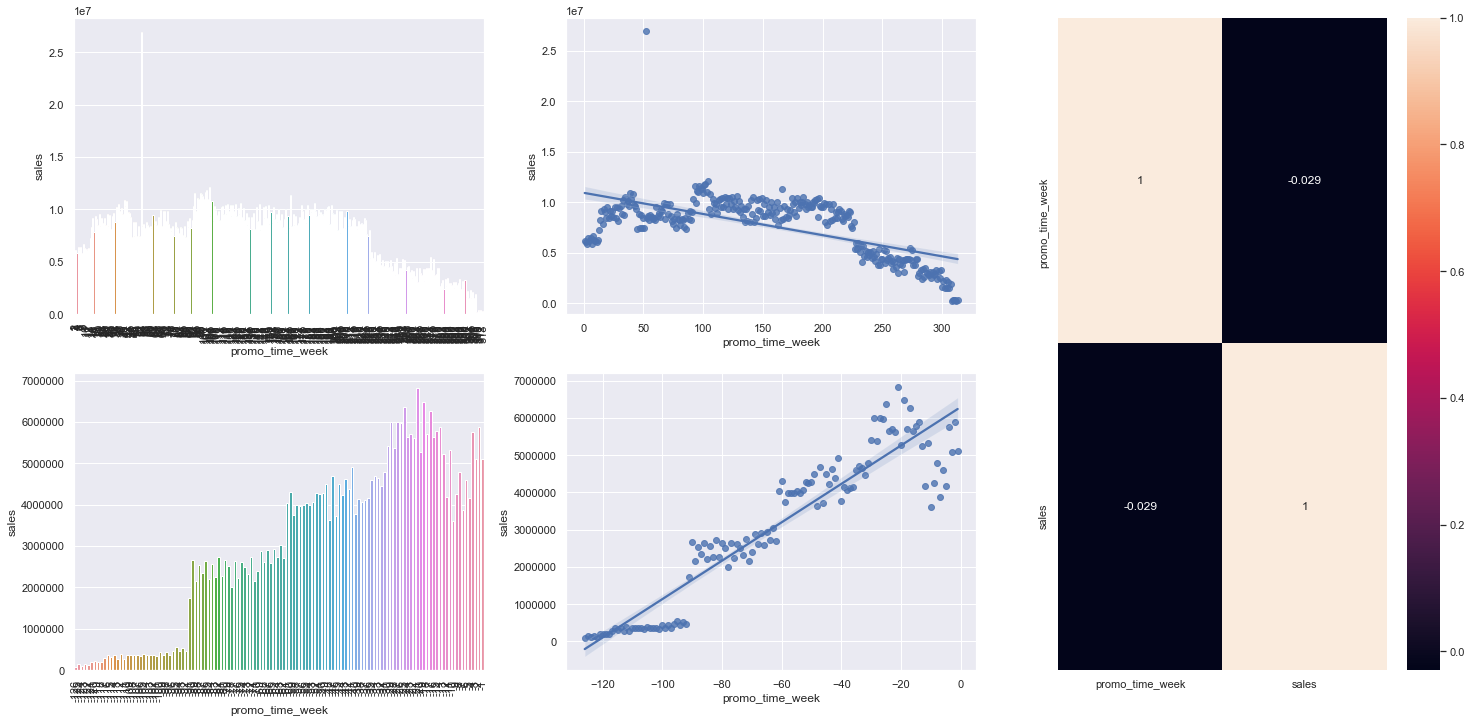

In [30]:
# when 'promo' ended up, 'promo_2' has started.
# if promo_time_week is positive, it is related with 'promo_2' (extended)
# If promo_time_week is negative, it is related with  'promo' (regular promo)
#plt.subplot(1, 3, 1 )
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2=aux1[aux1['promo_time_week'] > 0 ] # extend promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3=aux1[aux1['promo_time_week'] < 0 ] # regular promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

# Insight: When store inform about promo, occurs the sale increasement. But extended promo has a time period.

# correlation --> Is not a relevant feature.
plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method = 'pearson'), annot=True);



### <s>**H5.** Stores with extended days sales should sell more. This hypothesis will be validated in the next CRISP.<s>

**H6.** Stores with consecutive sales should sell more.

**H6. Validation = False:** Stores with consecutive sales  **sell less.**

In [31]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


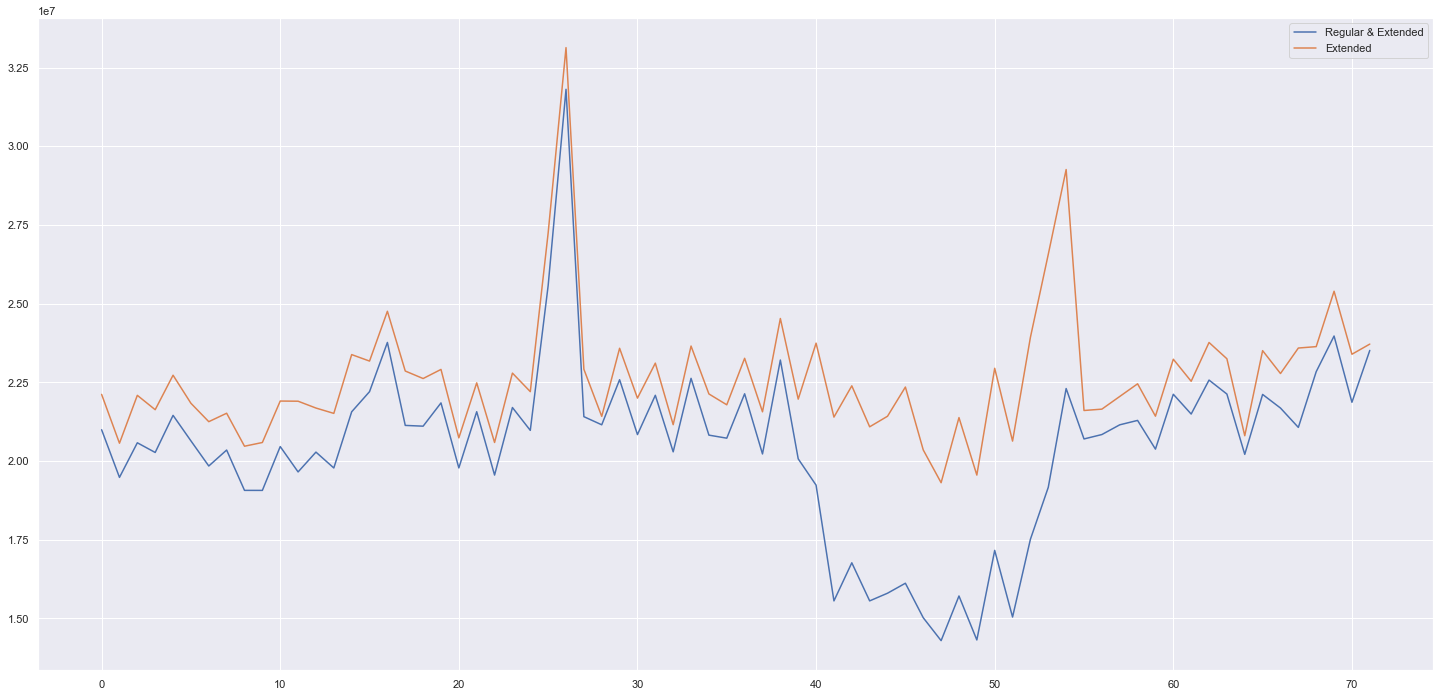

In [32]:
# Stores that joined a regular promo and extended promo
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()         

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)  

ax.legend( labels=['Regular & Extended', 'Extended']);

**H7.** During Chirstmas, stores should sell more.



**H7. Validation = False:** During Chirstmas holiday, stores **sell less.**

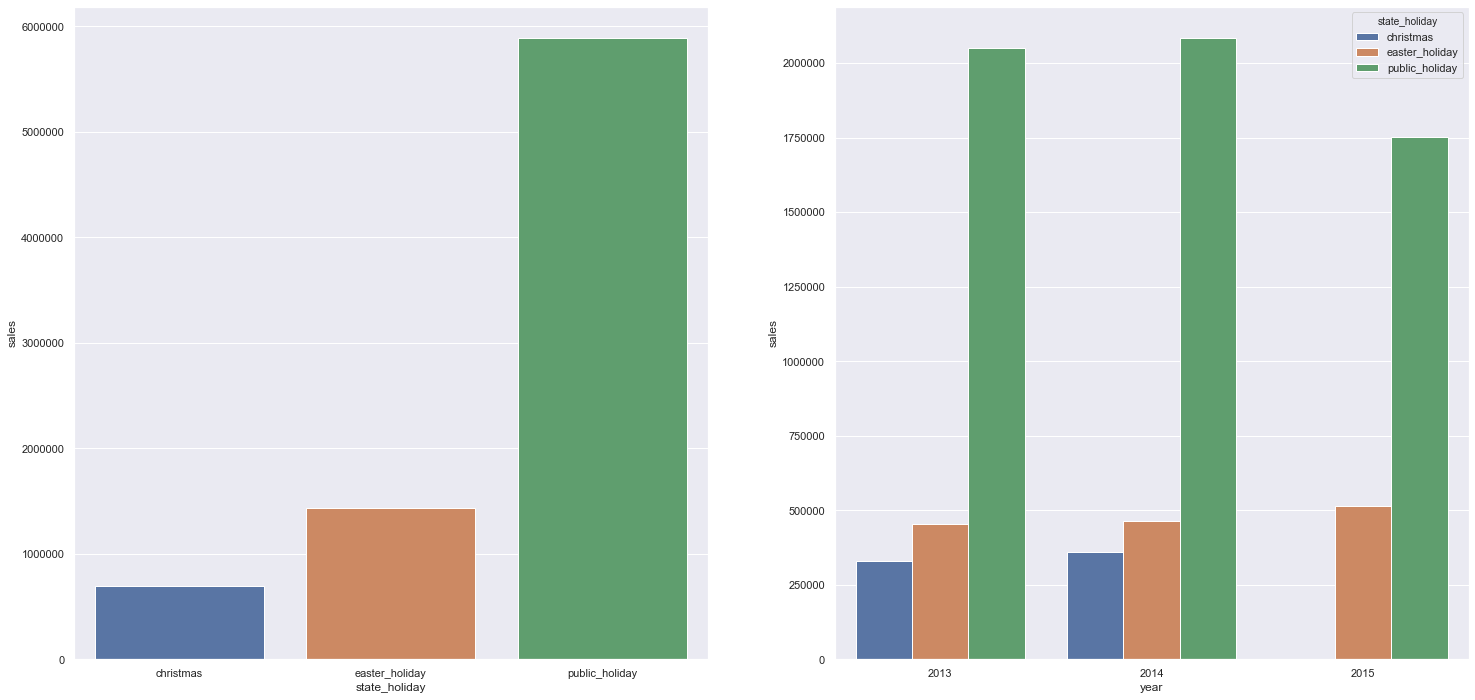

In [33]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 )

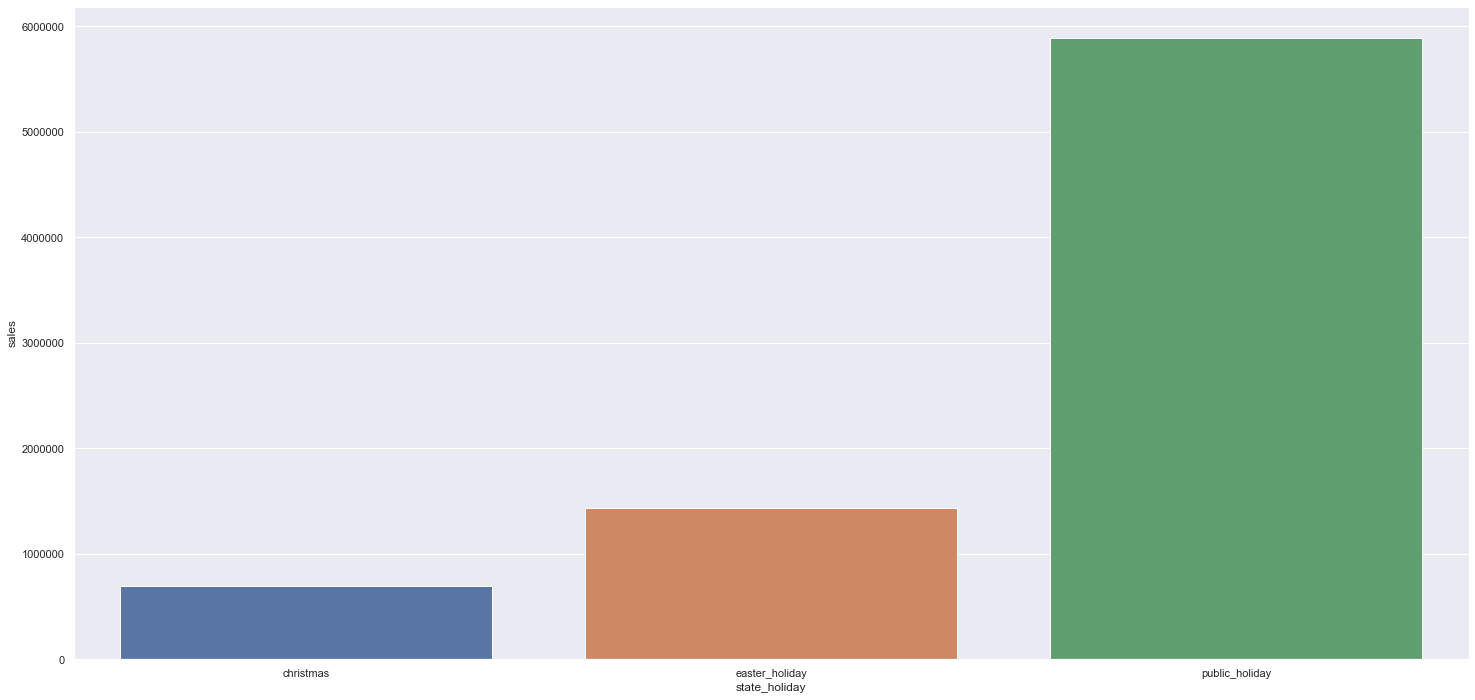

In [34]:

sns.barplot( x = 'state_holiday', y = 'sales', data = aux1);



**H8.** Over the years stores should sell more.

**H8. Validation = False:** Over the years stores **sell less.**

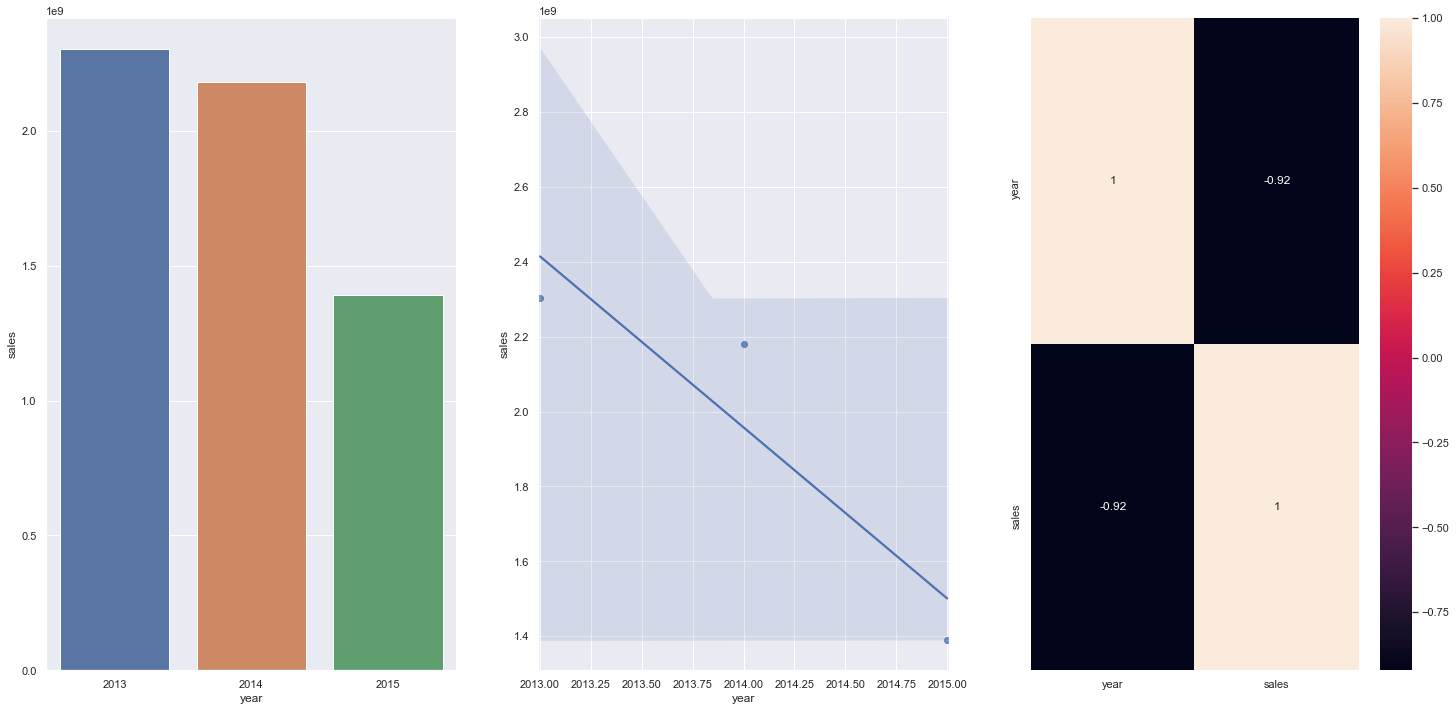

In [35]:
plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot( x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'year', y = 'sales', data = aux1);

# strong negative correlation. Over the years, sales fall.
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H9.** During the second semester, stores should sell more.

**H9. Validation = False:** During the second semester, stores  **sell less.**

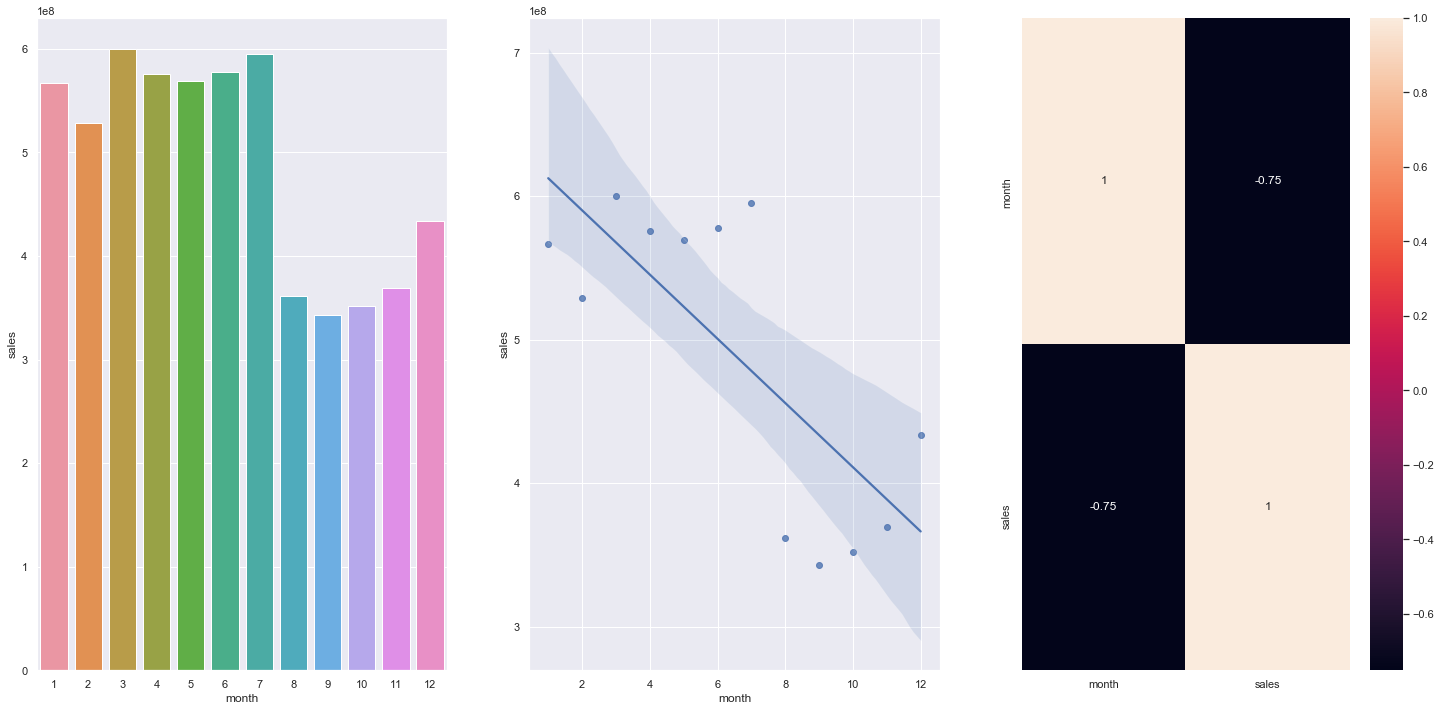

In [36]:
# H9 is an important feature.
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot( x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'month', y = 'sales', data = aux1);

# strong negative correlation. Over the years, sales fall.
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);




**H10.** After day 10 of each month, stores shoud sell more.

**H10.** Validation = True: After day 10 of each month, stores **sell more.**

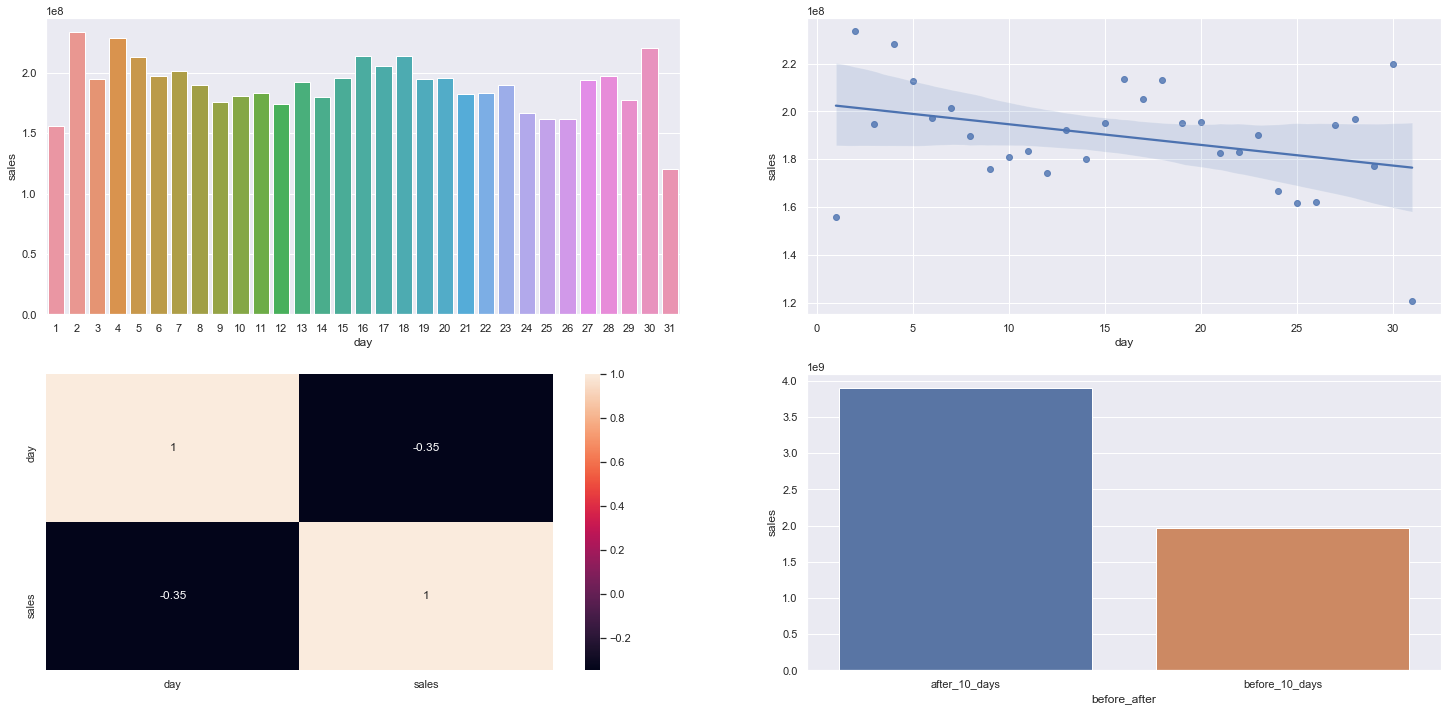

In [37]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot( x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot( x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);


**H11.** During weekends ,stores should sell less.

**H11.** Validation = True: During weekends, stores **sell less.**

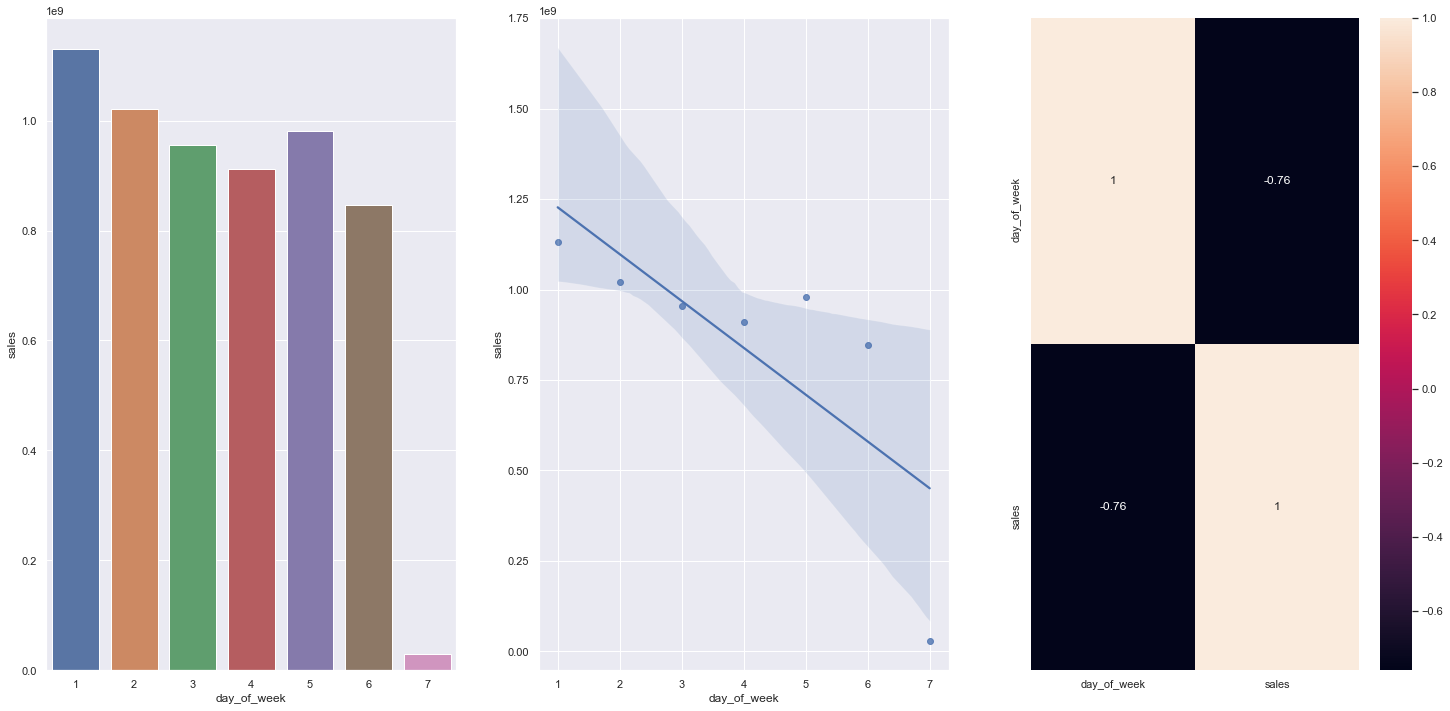

In [38]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'day_of_week', y = 'sales', data = aux1);

# Strong negative correlation.
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H12.** During school holidays, stores should sell less.

**H12. Validation = True:** During school holidays, stores **sell less.** Except in July an August, because sales are similar between regular day and school holiday.

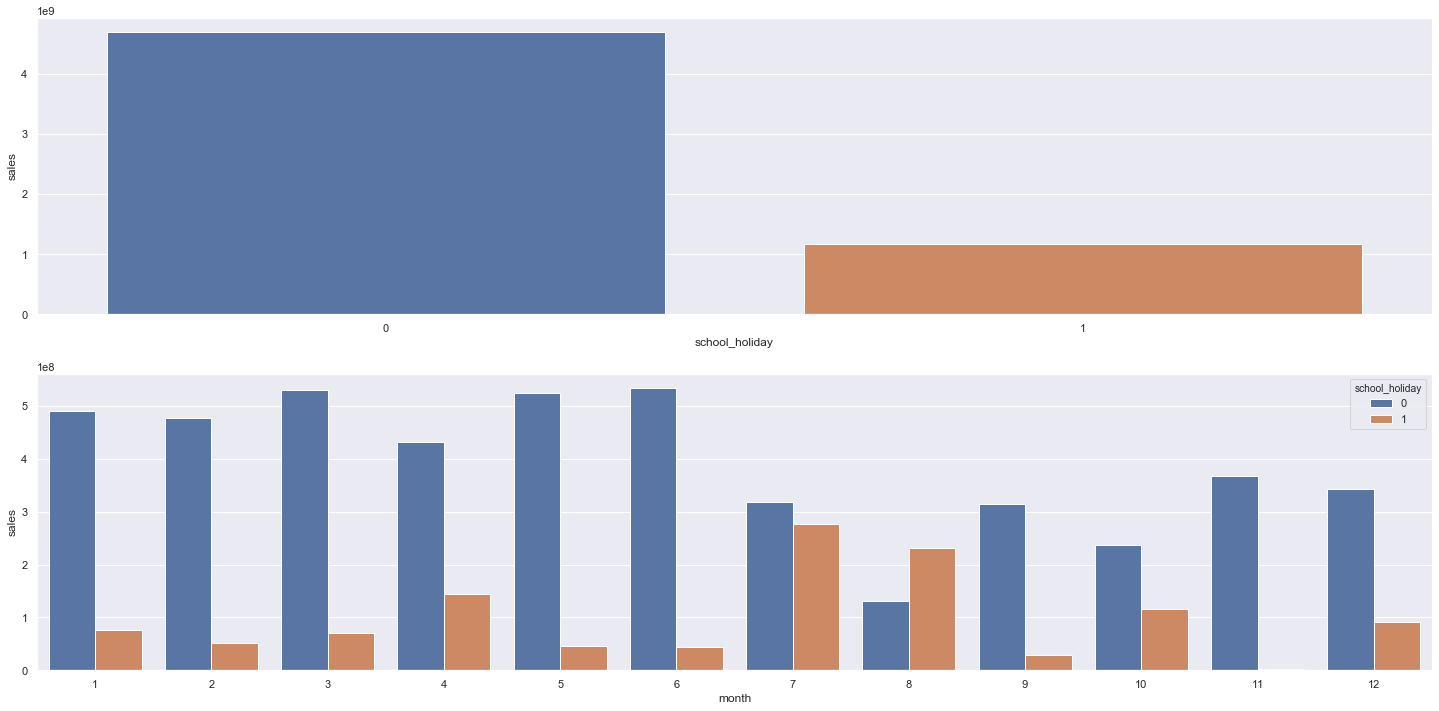

In [39]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

#### 4.2.1 Summary oh Hypothesis

In [40]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Medium'],
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Medium'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low']
      ]
print( tabulate( tab, headers = 'firstrow'))
    

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

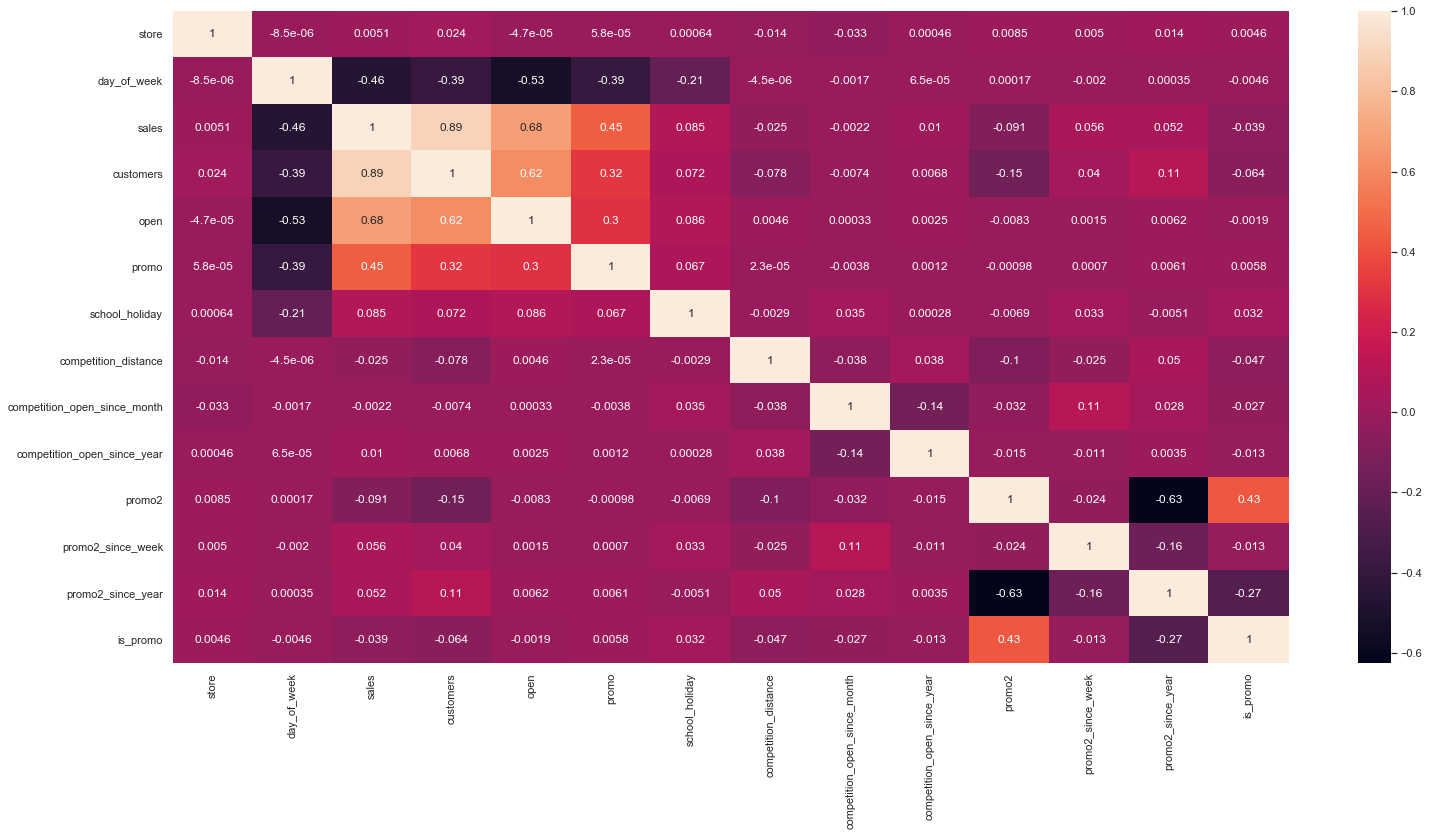

In [41]:
correlation = num_attributes.corr( method = 'pearson')
sns.heatmap(correlation, annot = True);

# 5.0 Data Preparation

In [42]:
df5 = df4.copy()

## 5.1 Standardization

## 5.2 Rescaling

In [43]:
a = df5.select_dtypes ( include = ['int64', 'float64'])

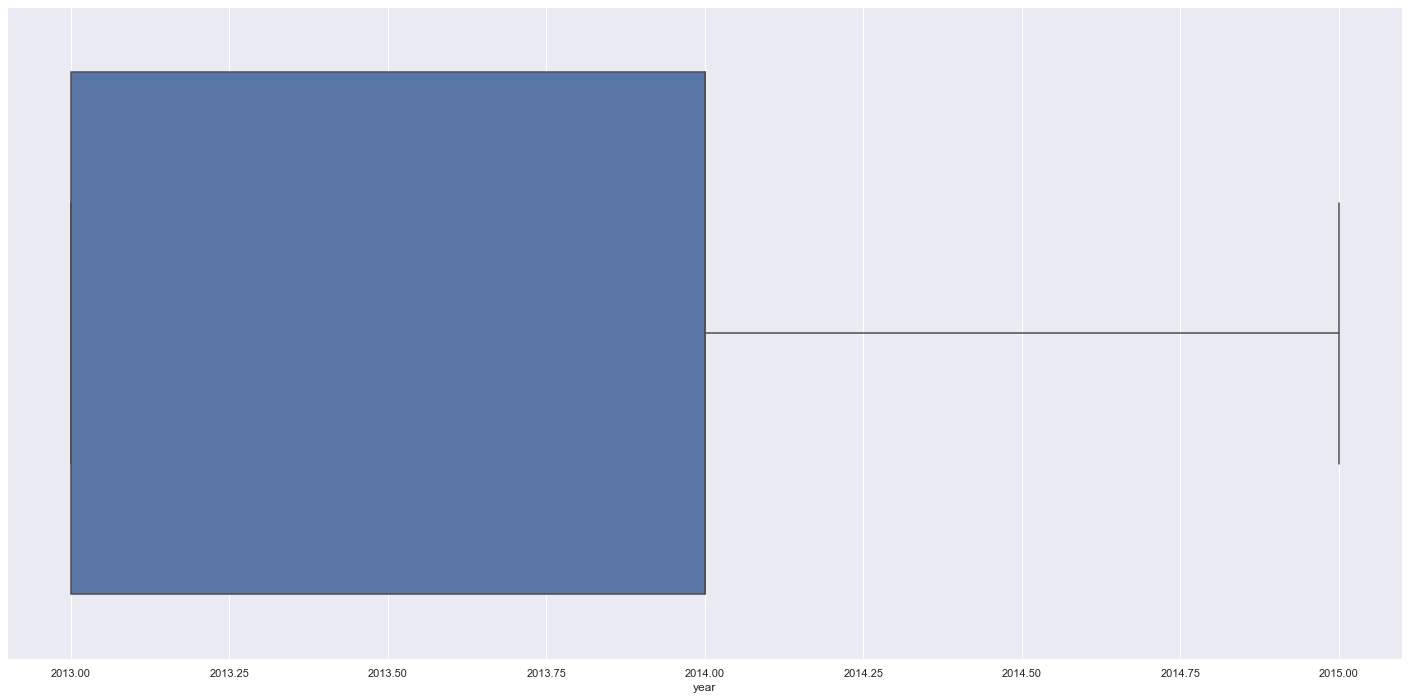

In [44]:
sns.boxplot(df5['year'])

In [45]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3  Encoding and Transcoding

### 5.3.1 Encoding

In [46]:
# state holiday - One Hot Encodig
df5 = pd.get_dummies (df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [47]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Responsible Varible Transformation

In [48]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [49]:
# day of week - 7 days in the week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7)))

# month - 12 months in the year
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12)))

# day - 30 days in the month
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30)))  


# week of year - 52 weeks in the year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52)))  


In [50]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Feature Selection

In [51]:
df6 = df5.copy()

## 6.1 Split Dataframe into Training and Test Dataset

In [52]:
# Delete columns that resulted others columns with changes
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis =1 )

In [53]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]-datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [54]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset - 6 weeks
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min()))
print( 'Training Max Date: {}'.format( X_train['date'].max()))

print( '\nTest Min Date: {}'.format( X_test['date'].min()))
print( 'Test Max Date: {}'.format( X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Fature Selector

In [55]:
# Training and Test Dataset for Boruta
# Drop date and sales columns because they are used in training
#X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
#Y_train_n = Y_train.values.ravel()

# Define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs = -1)

# Define Boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

### 6.0.1 Best Features from Boruta

In [56]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [57]:
#cols_selected_boruta

In [58]:
#cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [59]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_sin',
     'month_cos',
     'day_of_week_sin',
     'day_of_week_cos',
     'day_sin',
     'day_cos',
     'week_of_year_cos',
     'week_of_year_sin'
     ]

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)


# 7.0 Machine Learning Modeling

In [60]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [61]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns = {'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Liner Regression Model

In [62]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict( x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [63]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3 Liner Regression Regularized Model - Lasso

In [64]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict( x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704879,0.289106,2744.451735


### 7.3.1 Lasso - Cross Validation

In [65]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4 Random Forest Regressor

In [66]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict( x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.237342,0.099644,1007.737624


### 7.4.1 Random Forest Regressor- Cross Validation

In [67]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.26+/-218.55,0.12+/-0.02,1255.72+/-318.58


## 7.5 Compare Models's Performance

### 7.5.2 Single Performance

In [69]:
modelling_result = pd.concat ([baseline_result, lr_result, lrr_result, rf_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.237342,0.099644,1007.737624
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704879,0.289106,2744.451735


### 7.5.2 Real Performance

In [70]:
modelling_result_cv = pd.concat ([lr_result_cv, lrr_result_cv, rf_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,Random Forest Regressor,837.26+/-218.55,0.12+/-0.02,1255.72+/-318.58


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [71]:
#param = {
#    'n_estimators' : [1500, 1700, 2500, 3000, 3500],
#    'n_jobs': [-2, -1, 1, 2],  
#   'max_depth': [3,6,8],
#    'min_weight_fraction_leaf': [0, 0.3, 0.5],
#    'max_leaf_nodes': [15, 20, 30]
#}

#MAX_EVAL = 5

In [72]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
    
#    # model
#    model_rf = RandomForestRegressor(n_estimators = hp['n_estimators'], 
#                                     n_jobs = hp['n_jobs'], 
#                                     max_depth = hp['max_depth'],
#                                     min_weight_fraction_leaf = hp['min_weight_fraction_leaf'],
#                                     max_leaf_nodes = hp['max_leaf_nodes'] )
#    # performance
#    result = cross_validation( x_training, 5, 'Random Forest Regressor', model_rf, verbose=True )
#    final_result = pd.concat( [final_result, result] )
        
#final_result

## 8.2 Final Model

In [78]:
with open('model_rossmall.pkl', 'wb') as file:
    pickle.dump(rf, file)

In [87]:
# overestimated  sales
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_rf))
mpe

-0.01909164894314089

# 9.0 Error Interpretation

In [104]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_rf)


In [105]:
df9.columns

Index(['store', 'promo', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'month_sin', 'month_cos', 'day_of_week_sin',
       'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_cos',
       'week_of_year_sin', 'date', 'sales', 'predictions'],
      dtype='object')

## 9.1 Business Performance

In [135]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on='store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [137]:
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,109661.101066,106050.040855,113272.161277,3611.060211,0.619138
908,909,248089.615362,241081.306002,255097.924722,7008.309360,0.483370
549,550,259350.409501,257539.668703,261161.150298,1810.740797,0.365600
875,876,212768.894030,208926.724609,216611.063451,3842.169421,0.297702
182,183,206095.711504,204511.157624,207680.265383,1584.553880,0.268658


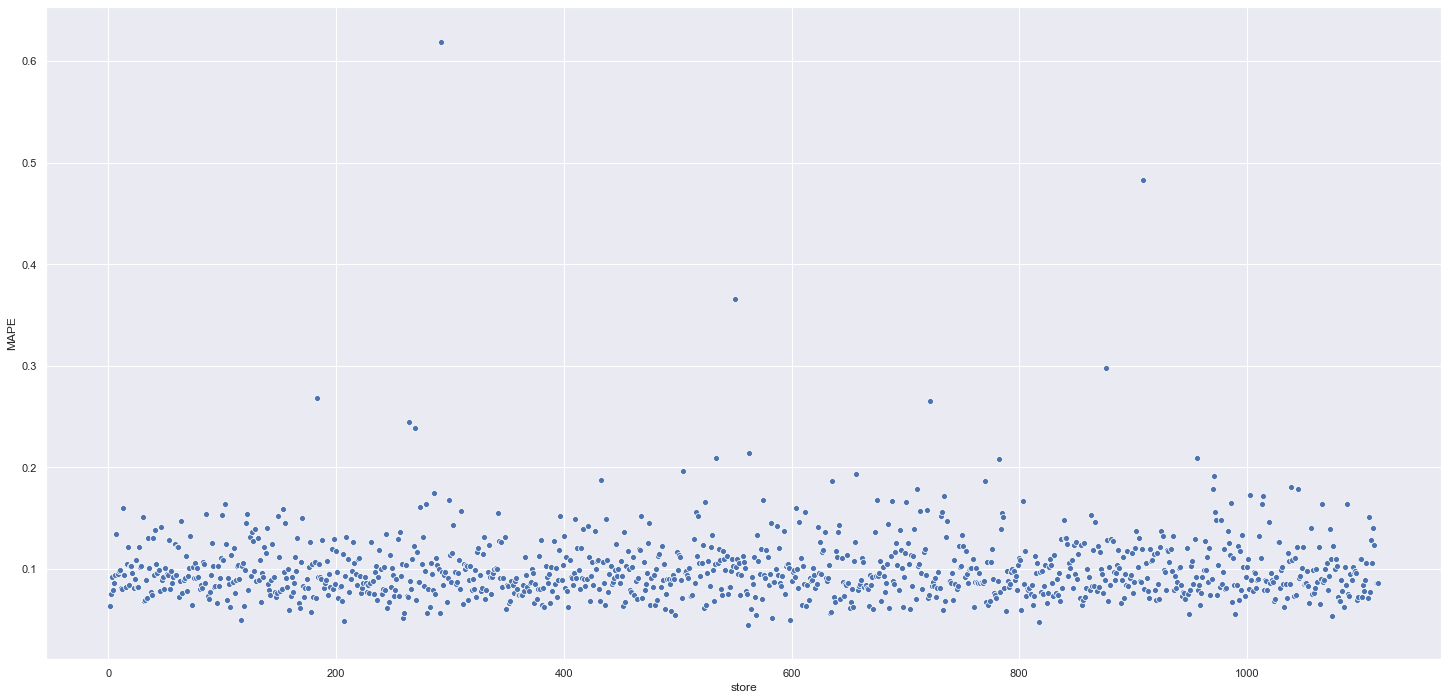

In [139]:
sns.scatterplot( x= 'store', y = 'MAPE', data = df92)

## 9.2 Total Performance

In [161]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns= {'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$289,363,940.87"
1,worst_scenario,"R$288,605,149.93"
2,best_scenario,"R$290,122,731.80"


## 9.3 Machine Learning Performance

In [162]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

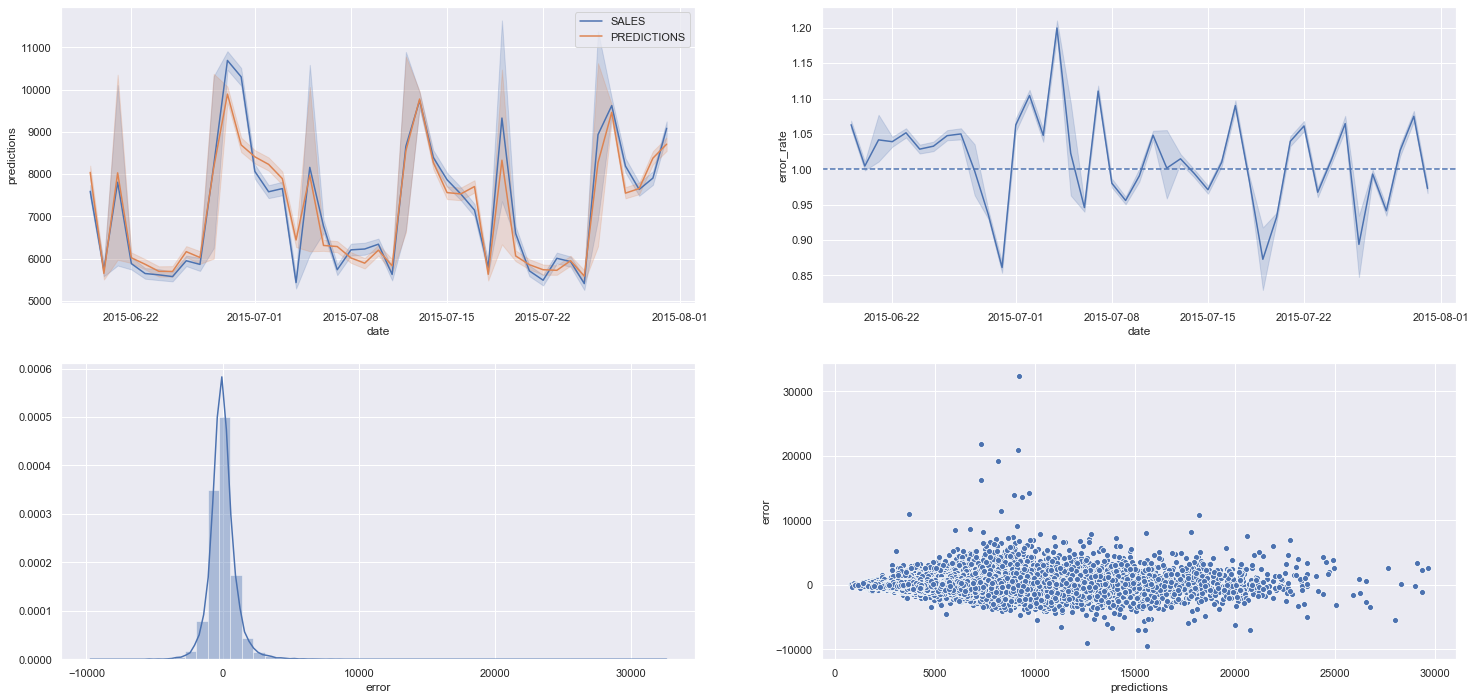

In [166]:
plt.subplot( 2, 2, 1)
sns.lineplot(x = 'date', y='sales', data = df9, label = 'SALES')
sns.lineplot(x = 'date', y='predictions', data = df9, label = 'PREDICTIONS')

# below 1.00 underestimation : predictions are lower than sales
# above 1.00 overestimated : predictions are greater than sales
plt.subplot( 2, 2, 2)
sns.lineplot( x = 'date', y = 'error_rate', data = df9)
plt.axhline( 1, linestyle= '--')

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'])

# Residual
plt.subplot( 2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])